In [ ]:
!pip install yahoo_fin
from yahoo_fin import stock_info as si
import datetime
%matplotlib inline
import math
import matplotlib
import multiprocessing
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from fbprophet import Prophet
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

end_date = datetime.date(2021,4,1)
data = si.get_data('RELIANCE.NS', end_date=end_date ,index_as_date=False)
data= data.dropna()
data=data.reset_index(drop=True)

df= pd.DataFrame(data)
data.head

df= df[['date', 'adjclose']].rename(columns={'date':'ds', 'adjclose':'y'})

print(df.head())

     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 92kB 7.9MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
  Created wheel for parse: filename=parse-1.19.0-cp37-none-any.whl size=24581 sha256=a0653e95ef30ce4a01f6e8560ae59a07fbaa38af6073181a284d980c37ba8686
  Stored in directory: /root/.cache/pip/wheels/c0/39/ea/e2fd678bd130953f5438470b8dfa529f00787e9b8b92b27467
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp37-none-any.whl size=13485 sha256=2d2a90f849dae06b4b5715354a55e17577b9d151da541d67814f4e295e831744
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-cp37-none-any.whl size=6067 sha256=858566c0802483281426be0e36f94c7bee64d07039fad0182c9c0b1f89358515
  Stored in directory: /root/.cache/pip/wheels/f1/80/5a/444ba08a550cdd241bd9baf8bae44be750efe370

In [ ]:
print(df.head())

          ds          y
0 1996-01-01  10.543346
1 1996-01-02  10.461358
2 1996-01-03  10.540785
3 1996-01-04  10.443419
4 1996-01-05  10.371678


In [ ]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [ ]:
def hyperparam_tune_cp_fo_wd(df, H, train_size, val_size, changepoint_prior_scale_list, 
                             fourier_order_list, window_list, holidays):
    """
    Hyperparameter tuning - changepoint, fourier_order, holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale_list: list of changepoint_prior_scale values to try
        fourier_order_list          : list of fourier_order values to try
        window_list                 : list of upper and lower window values to try
        holidays                    : dataframe containing holidays you will like to model. 
                                      Must have 'holiday' and 'ds' columns
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    cp_list = []
    fo_list = []
    wd_list = []
    for changepoint_prior_scale in tqdm_notebook(changepoint_prior_scale_list):
        for fourier_order in tqdm_notebook(fourier_order_list):
            for window in tqdm_notebook(window_list):
                
                if window is None:
                    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          changepoint_prior_scale, 
                                                                          fourier_order, 
                                                                          holidays=None)
                else:
                    # Add lower_window and upper_window which extend the holiday out to 
                    # [lower_window, upper_window] days around the date
                    holidays['lower_window'] = -window
                    holidays['upper_window'] = +window
        
                    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          changepoint_prior_scale, 
                                                                          fourier_order, 
                                                                          holidays)
                rmse_mean_list.append(rmse_mean)
                mape_mean_list.append(mape_mean)
                mae_mean_list.append(mae_mean)
                cp_list.append(changepoint_prior_scale)
                fo_list.append(fourier_order)
                wd_list.append(window)
        
    # Return hyperparam corresponding to lowest error metric
    results = pd.DataFrame({'changepoint_prior_scale': cp_list, 
                            'fourier_order': fo_list,
                            'window': wd_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    temp = results[results['rmse'] == results['rmse'].min()]
    changepoint_prior_scale_opt = temp['changepoint_prior_scale'].values[0]
    fourier_order_opt = temp['fourier_order'].values[0]
    window_opt = temp['window'].values[0]
    
    return changepoint_prior_scale_opt, fourier_order_opt, window_opt, results

def get_error_metrics(df, H, train_size, val_size, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale: to detect changepoints in time series analysis trajectories
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    assert len(df) == train_size + val_size
    
    # Predict using Prophet, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}
    
    rmse_mean, mape_mean, mae_mean = get_preds_prophet_parallelized(df, H, changepoint_prior_scale, fourier_order, holidays)

    return rmse_mean, mape_mean, mae_mean, _


def get_preds_prophet_parallelized(df, H, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    This is a parallelized implementation of get_preds_prophet.
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale: to detect changepoints in time series analysis trajectories
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    inputs = range(train_size, len(df)-H, int(H/2))

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i, df, H, changepoint_prior_scale, fourier_order, holidays) for i in inputs)
    # results has format [(rmse1, mape1, mae1), (rmse2, mape2, mae2), ...]

    rmse = [errors[0] for errors in results]
    mape = [errors[1] for errors in results]
    mae = [errors[2] for errors in results]
    
    return np.mean(rmse), np.mean(mape), np.mean(mae)

def processInput(i, df, H, changepoint_prior_scale, fourier_order, holidays):
    preds_list = get_preds_prophet(df[i-train_size:i], H, changepoint_prior_scale, fourier_order, holidays)
    
    # Compute error metrics
    rmse = get_rmse(df[i:i+H]['y'], preds_list)
    mape = get_mape(df[i:i+H]['y'], preds_list)
    mae = get_mae(df[i:i+H]['y'], preds_list)
    
    return (rmse, mape, mae)

def get_preds_prophet(df, H, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    Use Prophet to forecast for the next H timesteps, starting at df[len(df)]
    Inputs
        df: dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H : forecast horizon
        changepoint_prior_scale : to detect changepoints in time series analysis trajectories
        fourier_order           : determines how quickly seasonality can change
        holidays                : dataframe containing holidays you will like to model. 
                                  Must have 'holiday' and 'ds' columns
    Outputs
        A list of predictions
    """
    # Fit prophet model
    if holidays is not None:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=holidays)
    else:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale,seasonality_mode='multiplicative')
    if (fourier_order is not None) and (~np.isnan(fourier_order)): # add monthly seasonality
        m.add_seasonality(name='monthly', period=21, fourier_order=int(fourier_order))

    m.fit(df)
    
    # Make future dataframe
    future1=data.date[:i+H]
#print(future1)
    f = pd.DataFrame({"ds": future1})
    
    # Predict
    forecast = m.predict(f) # Note this prediction includes the original dates
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    return forecast['yhat'][len(df):len(df)+H]

In [ ]:
# Get optimum hyperparams
train_size = int(data[data['date']=='2017-12-29'].index.values)                # Use data before 2019
val_size = int(data[data['date']=='2019-1-1'].index.values)- train_size                 # Use 1 year of data as validation of year=2019
train_val_size = train_size + val_size # Size of train+validation set
i = train_val_size                     # Day to forecast
H =  int(data[data['date']=='2019-12-31'].index.values)-train_val_size                # total days in 2020
h=   int(data[data['date']=='2020-12-31'].index.values)-train_val_size-H
h1=   int(data[data['date']=='2021-3-31'].index.values)-train_val_size-H-h
changepoint_prior_scale_list =[0.05,0.25, 0.5,0.75, 1,1.25, 1.5,2]     # for hyperparameter tuning
fourier_order_list = [None, 3, 6, 9]                 # for hyperparameter tuning
#holidays_path = "./data/holidays.csv"                       # csv file containing holidays in the US
window_list = [None]                               # for hyperparameter tuning

fontsize = 14
ticklabelsize = 14
hols= [None]
tic = time.time()
changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
    hyperparam_tune_cp_fo_wd(df[i-train_val_size:i], 
                             H, 
                             train_size, 
                             val_size, 
                             changepoint_prior_scale_list,
                             fourier_order_list,
                             window_list,hols)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("changepoint_prior_scale_opt = " + str(changepoint_prior_scale_opt))
print("fourier_order_opt = " + str(fourier_order_opt))
print("window_opt = " + str(window_opt))
results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Time taken = 8.580168747901917 mins
changepoint_prior_scale_opt = 0.75
fourier_order_opt = 6.0
window_opt = None


,changepoint_prior_scale,fourier_order,window,rmse,mape(%),mae
0,0.05,NaN,None,318.956261,29.249167,303.756881
1,0.05,3.0,None,318.931410,29.243545,303.709100
2,0.05,6.0,None,318.729476,29.224606,303.513503
3,0.05,9.0,None,318.883174,29.242131,303.685951
4,0.25,NaN,None,317.588879,29.102734,302.295240
5,0.25,3.0,None,317.838847,29.132085,302.583353
6,0.25,6.0,None,317.650113,29.112208,302.382495
7,0.25,9.0,None,317.806260,29.125400,302.523783
8,0.50,NaN,None,317.561204,29.101573,302.280425
9,0.50,3.0,None,317.418931,29.090294,302.157351


In [ ]:
preds_list = get_preds_prophet(df[i-train_val_size:i], H+h+h1,   changepoint_prior_scale_opt, fourier_order_opt )
print(preds_list.tail())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6342    1217.237087
6343    1222.990300
6344    1227.409127
6345    1228.902312
6346    1240.143535
Name: yhat, dtype: float64


(737060.0, 737421.0)

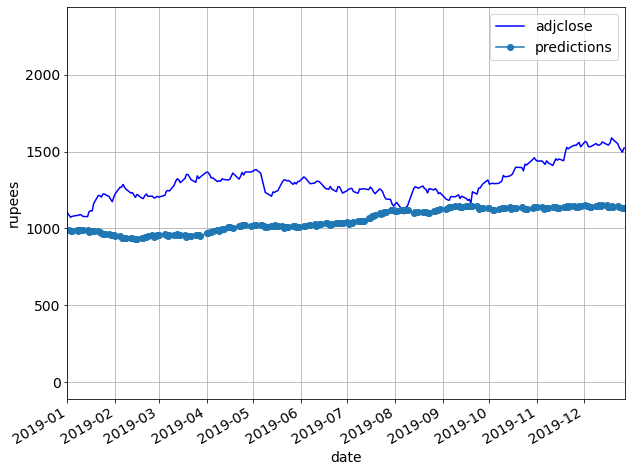

In [ ]:
# Plot the predictions

rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = data.plot(x='date', y='adjclose', style='b-', grid=True)

# Plot the predictions
ax.plot(data['date'][i:i+H], preds_list[:H], marker='o')
    
ax.set_xlabel("date")
ax.set_ylabel("rupees")
ax.legend(['adjclose', 'predictions'])
#ax.set_ylim([1200, 1300])
ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2019, 12, 28)])

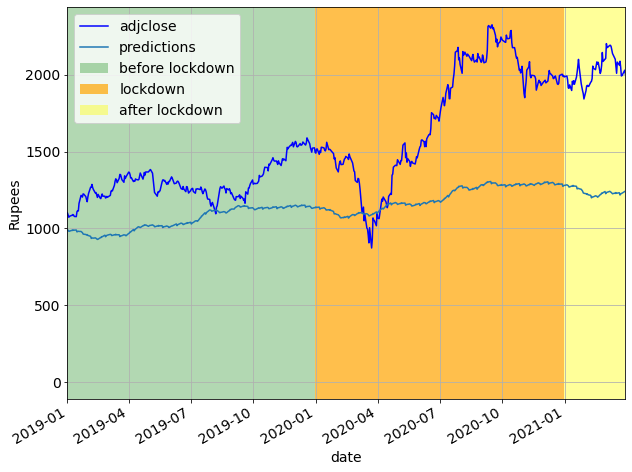

In [ ]:
# Plot the predictions

rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = data.plot(x='date', y='adjclose', style='b-', grid=True)

# Plot the predictions
ax.plot(data['date'][i:i+H+h+h1], preds_list)
    
ax.set_xlabel("date")
ax.set_ylabel("Rupees")
ax.legend(['adjclose', 'predictions'])
#ax.set_ylim([1200, 1300])
ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2021, 3, 31)])
ax.axvspan(datetime.date(2019, 1, 1), datetime.date(2019, 12, 31), facecolor='green', alpha=0.3,label='before pandemic')
ax.axvspan(datetime.date(2019, 12, 31), datetime.date(2020, 12, 31), facecolor='orange', alpha=0.7,label='pandemic')
ax.axvspan(datetime.date(2020, 12, 31), datetime.date(2021, 3, 31), facecolor='yellow', alpha=0.4,label='after pandemic')
ax.legend(['adjclose', 'predictions','before lockdown', 'lockdown','after lockdown'])

In [ ]:
print("for the session 2019, the RMSE is %f" % ( get_rmse(df[i:i+H]['y'], preds_list[:H])))
print("for the session 2019, the mean MAPE is %f" % ( get_mape(df[i:i+H]['y'], preds_list[:H])))

for the session 2019, the RMSE is 267.866295
for the session 2019, the mean MAPE is 18.422353


In [ ]:

print("for the year 2020, the RMSE is %f" % ( get_rmse(df[i+H:i+H+h]['y'], preds_list[H:H+h])))
print("for the year 2020 the mean MAPE is %f" % ( get_mape(df[i+H:i+H+h]['y'], preds_list[H:H+h])))

for the year 2020, the RMSE is 613.681872
for the year 2020 the mean MAPE is 29.084666


In [ ]:
print("for the year 2021, the RMSE is %f" % ( get_rmse(df[i+H+h:i+H+h+h1]['y'], preds_list[H+h:H+h+h1])))
print("for the year 2021 the mean MAPE is %f" % ( get_mape(df[i+H+h:i+H+h+h1]['y'], preds_list[H+h:H+h+h1])))

for the year 2021, the RMSE is 791.012666
for the year 2021 the mean MAPE is 38.673998
